# Conflict Impact Analysis in Middle East, North Africa, Pakistan and Afghanistan

This analysis looks at conflicts between 2020 and 2024 in MENA + AP countries. Using ACLED data, we visualize number of events, conflict and conflict intensity index. 

ACLED consists of different event types and sub event types. For the purpose of this analysis, peaceful protests have not been considered.

In [394]:
%reload_ext autoreload
%autoreload 2

import os
import acled_conflict_analysis as acled
from acled_conflict_analysis import visuals
from acled_conflict_analysis import processing
from acled_conflict_analysis import extraction


from bokeh.plotting import show, output_notebook
from bokeh.io import output_file

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs, TabPanel, HoverTool

from datetime import date
from datetime import datetime
import geopandas as gpd
import pandas as pd
from conflict_visuals import *

In [150]:
countries_of_interest = [
    "Afghanistan","Pakistan","Algeria","Morocco","Libya","Yemen","Iran", "Iraq",
    "Syria","Egypt","Lebanon","Djibouti","United Arab Emirates","Jordan","Palestine",
    "Oman", "Qatar", "Saudi Arabia", "Kuwait", "Tunisia", "Bahrain", "Sudan", "Mauritania","Somalia"]
START_DATE1 = "2019-01-01"
END_DATE1 = "2020-12-31"

START_DATE2 = "2021-01-01"
END_DATE2 = "2022-12-31"

START_DATE3 = "2023-01-01"
END_DATE3 = "2024-12-31"

In [59]:
os.environ['ACLED_EMAIL'] = extraction.get_acled_credentials()[0]
os.environ['ACLED_KEY'] = extraction.get_acled_credentials()[1]

In [151]:
data1 = extraction.acled_api(
    # email_address=os.environ.get("ACLED_EMAIL"),
    # access_key=os.environ.get("ACLED_KEY"),
    countries=countries_of_interest,
    start_date=START_DATE1,
    end_date=END_DATE1
)

data2 = extraction.acled_api(
    countries=countries_of_interest,
    start_date=START_DATE2,
    end_date=END_DATE2
)

data3 = extraction.acled_api(
    countries=countries_of_interest,
    start_date=START_DATE3,
    end_date=END_DATE3
)

data = pd.concat([data1, data2, data3], ignore_index=True)

🔄 Using cached OAuth token
✅ Successfully retrieved 154704 records
✅ Successfully retrieved 154704 records
🔄 Using cached OAuth token
🔄 Using cached OAuth token
✅ Successfully retrieved 135356 records
🔄 Using cached OAuth token
✅ Successfully retrieved 135356 records
🔄 Using cached OAuth token
✅ Successfully retrieved 178655 records
✅ Successfully retrieved 178655 records


In [155]:
data.drop_duplicates(inplace=True)
data.shape

(468616, 19)

In [156]:
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data.sort_values(by='timestamp', inplace=True, ascending=False)

In [205]:
processing.data_type_conversion(data)

In [206]:
data = data[data['sub_event_type']!='Peaceful protest']

In [207]:
extracted_date = datetime.today().strftime('%Y%m%d')

last_date = data['event_date'].max()
last_date = last_date.strftime('%d %B %Y')
extracted_date_formatted = datetime.today().strftime('%d %B %Y')

In [208]:
data.to_csv(f'../../data/conflict/acled_mena_raw_no_peaceful_protest_{extracted_date}.csv')

In [360]:
conflict_national = processing.get_acled_by_group(data, columns=['country'], freq='YS')
conflict_national = conflict_national.groupby(['country'])[['nrEvents', 'nrFatalities']].sum().reset_index()

data_no_protest = data[data['event_type'] != 'Protests']
conflict_national_no_protest = processing.get_acled_by_group(data_no_protest, columns=['country'], freq='YS')
conflict_national_no_protest = conflict_national_no_protest.groupby(['country'])[['nrEvents', 'nrFatalities']].sum().reset_index()

In [210]:
conflict_national_event_type_monthly = processing.get_acled_by_group(data, columns=['country', 'event_type'], freq='MS')
conflict_national_event_type_monthly.to_csv(f'../../data/conflict/conflict_national_events_monthly_{extracted_date}.csv')

## Regional Events and Fatalities

In [211]:
conflict_national.loc[conflict_national['country']=='Palestine', 'country'] = 'West Bank and Gaza'
#regional_boundary_grids.loc[regional_boundary_grids['country'] == 'Syrian Arab Republic', 'country'] = 'Syria'

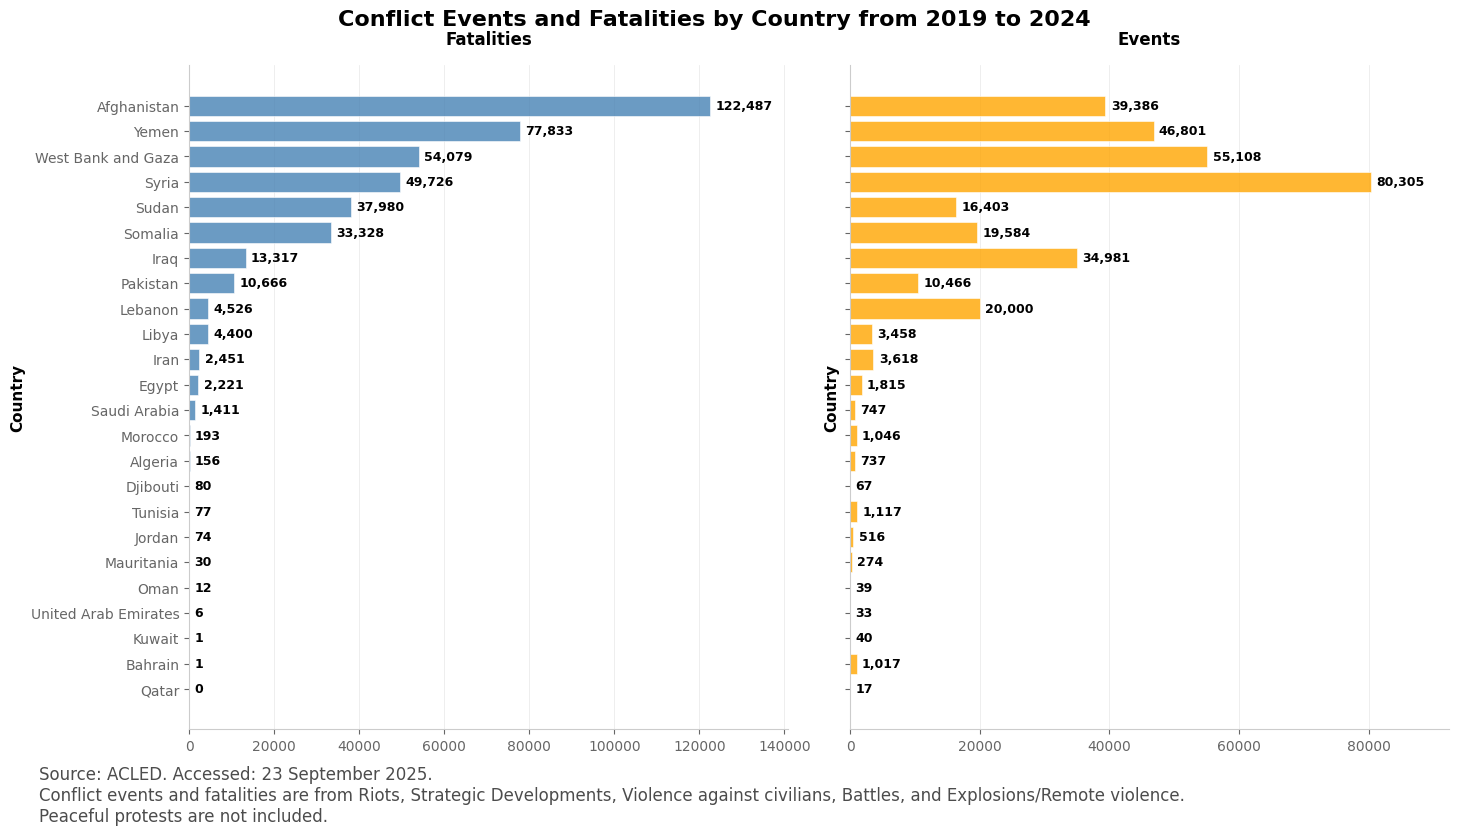

In [213]:
plot_dual_metrics_by_country(
    data =conflict_national,
    metrics_to_plot =['nrFatalities', 'nrEvents'],
    metric_display_info = {'nrFatalities': {'title': 'Fatalities', 'color': 'steelblue'},
                           'nrEvents': {'title': 'Events', 'color': 'orange'}},
    sorting_metric = 'nrFatalities',
    overall_title = 'Conflict Events and Fatalities by Country from 2019 to 2024',
    subtitle = f"""Source: ACLED. Accessed: {extracted_date_formatted}.\nConflict events and fatalities are from Riots, Strategic Developments, Violence against civilians, Battles, and Explosions/Remote violence.\nPeaceful protests are not included."""
);

In [214]:
highest_15 = conflict_national[['country', 'nrFatalities']].sort_values(by='nrFatalities', ascending=False).head(15).reset_index(drop=True)['country'].tolist()

In [215]:
import glob
boundaries_adm0 = gpd.GeoDataFrame()

for file in glob.glob('../../data/boundaries/*_ADM0_*.geojson'):
    gdf = gpd.read_file(file)
    boundaries_adm0 = pd.concat([boundaries_adm0, gdf], ignore_index=True)

boundaries_adm1 = gpd.GeoDataFrame()

for file in glob.glob('../../data/boundaries/*_ADM1_*.geojson'):
    gdf = gpd.read_file(file)
    boundaries_adm1 = pd.concat([boundaries_adm1, gdf], ignore_index=True)

boundaries_adm2 = gpd.GeoDataFrame()

for file in glob.glob('../../data/boundaries/*_ADM2_*.geojson'):
    gdf = gpd.read_file(file)
    boundaries_adm2 = pd.concat([boundaries_adm2, gdf], ignore_index=True)

In [216]:
from boundaries_utils import *

In [217]:
regional_boundary_quadkey7 = gpd.read_file('../../data/boundaries/MENAP_regional_quadkey7.gpkg')
regional_boundary_quadkey12 = gpd.read_file('../../data/boundaries/MENAP_regional_quadkey12.gpkg')
#regional_boundary_h3_4 = gpd.read_file('../../data/boundaries/')
regional_boundary_quadkey12['country'] = regional_boundary_quadkey12['country'].apply(lambda x: get_country_name_from_iso_code(x))


In [218]:
def get_national_conflict_at_aggregation(boundary, index_column, data):
    df = processing.get_acled_by_admin(boundary[[index_column, 'geometry']], data, columns=[index_column, 'country'], freq='YS')
    df = df.groupby([index_column, 'country'])[['nrEvents', 'nrFatalities']].sum().reset_index()
    #df = df.merge(boundary[[index_column, 'geometry']], on=index_column, how='left')
    df = processing.calculate_conflict_index(df)
    df = df.merge(boundary, on=[index_column, 'country'], how='left')
    df= gpd.GeoDataFrame(df, crs='EPSG:4326', geometry='geometry')
    df['region'] = 'Middle East, North Africa, Afghanistan and Pakistan'

    return df

def get_conflict_at_aggregation(boundary, index_column, data):
    df = processing.get_acled_by_admin(boundary[[index_column, 'geometry']], data, columns=[index_column], freq='YS')
    df = df.groupby([index_column])[['nrEvents', 'nrFatalities']].sum().reset_index()
    #df = df.merge(boundary[[index_column, 'geometry']], on=index_column, how='left')
    df = processing.calculate_conflict_index(df)
    df = df.merge(boundary, on=[index_column], how='left')
    df= gpd.GeoDataFrame(df, crs='EPSG:4326', geometry='geometry')
    df['region'] = 'Middle East, North Africa, Afghanistan and Pakistan'

    return df

In [219]:
conflict_regional_quad12_quarter = processing.get_acled_by_admin(regional_boundary_quadkey12[['index', 'geometry']],data, ['index', 'country'], freq='QS')
conflict_regional_quad12_quarter = processing.calculate_conflict_index(conflict_regional_quad12_quarter)

In [220]:
conflict_regional_quad12_quarter.to_csv(f'../../data/conflict/conflict_quad12_regional_quarterly_{extracted_date}.csv')

In [221]:
regional_boundary_h3_4 = processing.convert_to_h3_grid(boundaries_adm0, 4)

In [363]:
# conflict_national_h3_4 = get_conflict_at_aggregation(regional_boundary_h3_4, 'h3_index', data)
# #conflict_national_q7 = get_national_conflict_at_aggregation(regional_boundary_quadkey7, 'index', data)
# conflict_national_q12 = get_national_conflict_at_aggregation(regional_boundary_quadkey12, 'index', data)
conflict_national_q12_noprotest= data[data['event_type'].isin(['Battles',  'Riots', 
       'Explosions/Remote violence', 'Violence against civilians'])]
conflict_national_q12_noprotest = get_national_conflict_at_aggregation(regional_boundary_quadkey12,'index', conflict_national_q12_noprotest )

In [73]:
#boundaries_quad12.reset_index().to_file('../../data/boundaries/MENAP_regional_quadkey12.gpkg')

## Geospatial Distribution of Conflict Intensity

In [223]:
conflict_national_h3_4.to_file(f'../../data/conflict/conflict_national_h3_4_{extracted_date}.geojson')

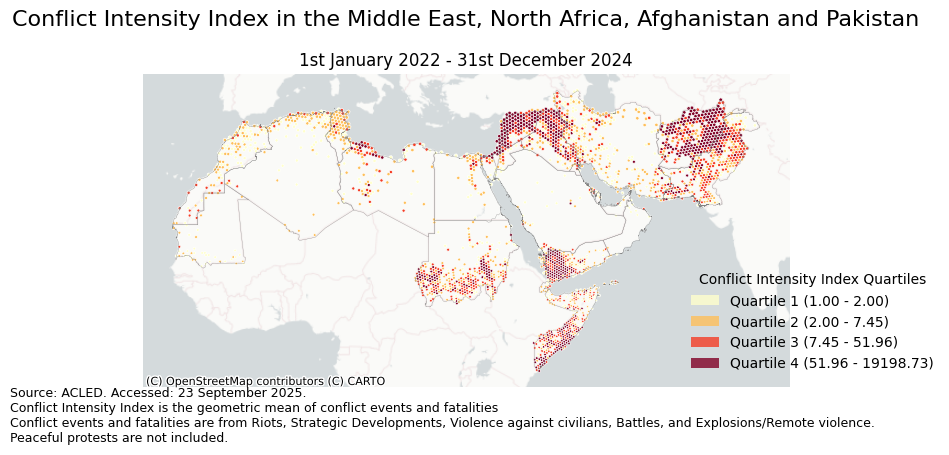

In [361]:
plot_h3_maps_with_boundaries_and_quartiles(
    conflict_national_h3_4,
    #title='Conflict Intensity Index at 1770 sq.km hex grids',
    category_column='region',
    measure_column='conflict_intensity_index',
    cmap_name='YlOrRd',
    boundary_gdf=boundaries_adm0,
    title = 'Conflict Intensity Index in the Middle East, North Africa, Afghanistan and Pakistan',
    source_text = f'Source: ACLED. Accessed: {extracted_date_formatted}.\nConflict Intensity Index is the geometric mean of conflict events and fatalities\nConflict events and fatalities are from Riots, Strategic Developments, Violence against civilians, Battles, and Explosions/Remote violence.\nPeaceful protests are not included.',
    #subtitle_prefix='',
    #subplot_figsize_per_map=(10,4)
    );

In [238]:
conflict_event_monthly = processing.get_acled_by_group(data, columns=['country', 'event_type'], freq='MS')

### Which country saw the most widespread conflict?

1. We divided each country into ~2.4km grids
2. Every grid that had atleast one fatality/events was counted
3. Percentage of area where conflict occured is calculated

In [239]:
regional_boundary_grids = regional_boundary_quadkey12.groupby(['country']).count().reset_index()
regional_boundary_grids.rename(columns={'index':'nrGrids'}, inplace=True)

In [240]:
# Replace specific value in a column
regional_boundary_grids.loc[regional_boundary_grids['country'] == 'Iran, Islamic Republic of', 'country'] = 'Iran'
regional_boundary_grids.loc[regional_boundary_grids['country'] == 'Palestine, State of', 'country'] = 'Palestine'
regional_boundary_grids.loc[regional_boundary_grids['country'] == 'Syrian Arab Republic', 'country'] = 'Syria'

In [241]:
import numpy as np

def get_spread(conflict_national_h3_7, metric, column_name = 'nrGridswithFatalities'):
    conflict_spread = conflict_national_h3_7[conflict_national_h3_7[metric]>0].groupby('country')[metric].count().reset_index()
    print(len(conflict_spread['country'].unique()))
    conflict_spread = conflict_spread.rename(columns={metric:column_name})

    conflict_spread = conflict_spread.merge(regional_boundary_grids, on='country')
    print(len(conflict_spread['country'].unique()))
    conflict_spread['conflictArea'] = np.round(100*conflict_spread[column_name] / conflict_spread['nrGrids'],2)

    return conflict_spread

In [242]:
conflict_spread_fatalities = get_spread(conflict_national_q12, 'nrFatalities')
conflict_spread_events = get_spread(conflict_national_q12, 'nrEvents')

23
23
24
24


In [230]:
conflict_spread_events.rename(columns={'conflictArea': 'conflictAreaEvents'}, inplace=True)
conflict_spread_fatalities.rename(columns={'conflictArea': 'conflictAreaFatalities'}, inplace=True)
conflict_spread = conflict_spread_events.merge(conflict_spread_fatalities, on='country')

In [231]:
conflict_spread.loc[conflict_spread['country'] == 'Palestine', 'country'] = 'West Bank and Gaza'

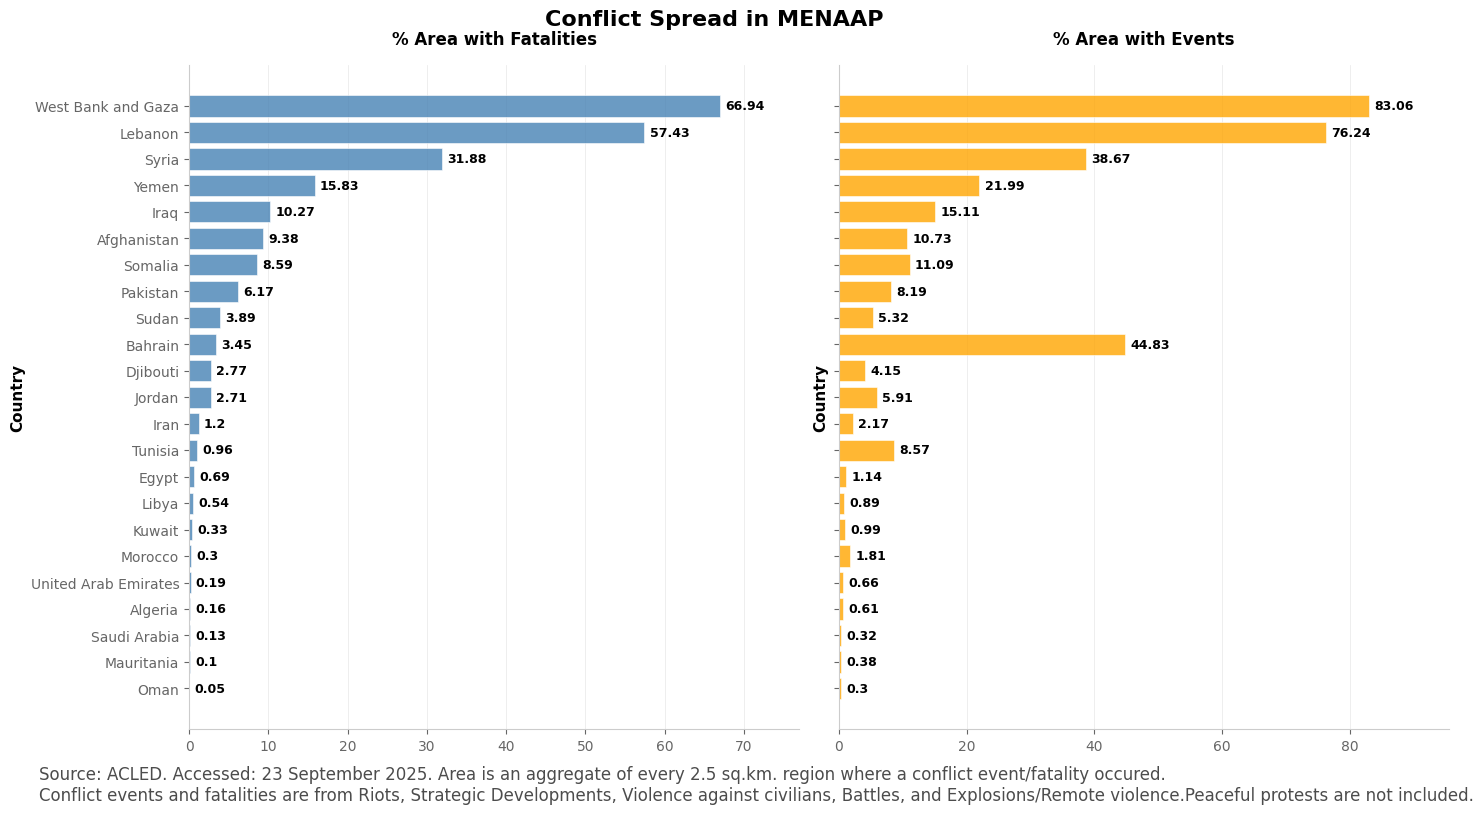

In [232]:
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('default')

plot_dual_metrics_by_country(
    data =conflict_spread,
    metrics_to_plot =['conflictAreaFatalities', 'conflictAreaEvents'],
    metric_display_info = {'conflictAreaFatalities': {'title': '% Area with Fatalities', 'color': 'steelblue'},
                           'conflictAreaEvents': {'title': '% Area with Events', 'color': 'orange'}},
    sorting_metric = 'conflictAreaFatalities',
    overall_title = 'Conflict Spread in MENAAP',
    subtitle = f"""Source: ACLED. Accessed: {extracted_date_formatted}. Area is an aggregate of every 2.5 sq.km. region where a conflict event/fatality occured.\nConflict events and fatalities are from Riots, Strategic Developments, Violence against civilians, Battles, and Explosions/Remote violence.Peaceful protests are not included."""
);

## Conflict Temporal Trends

In [233]:
data['wb_region'] = 'MENAAP'

In [234]:
conflict_regional_yearly = processing.get_acled_by_group(data, ['wb_region'],freq='YS')
conflict_regional_monthly = processing.get_acled_by_group(data, ['wb_region'],freq='MS')

In [235]:
event_dict = {datetime(2023,10,8):'Start of the Gaza War'}

In [236]:
# Debug: Check data structure for visualization
print("Data shape:", conflict_regional_monthly.shape)
print("\nColumns:", conflict_regional_monthly.columns.tolist())
print("\nFirst few rows:")
print(conflict_regional_monthly.head())
print("\nData types:")
print(conflict_regional_monthly.dtypes)
print("\nDate range:")
if 'event_date' in conflict_regional_monthly.columns:
    print(f"From: {conflict_regional_monthly['event_date'].min()}")
    print(f"To: {conflict_regional_monthly['event_date'].max()}")

# Check for any missing values that might cause hover issues
print("\nMissing values:")
print(conflict_regional_monthly.isnull().sum())

Data shape: (72, 4)

Columns: ['event_date', 'wb_region', 'nrFatalities', 'nrEvents']

First few rows:
  event_date wb_region  nrFatalities  nrEvents
0 2019-01-01    MENAAP          9053      5064
1 2019-02-01    MENAAP          6872      4506
2 2019-03-01    MENAAP          8835      5314
3 2019-04-01    MENAAP          8284      5144
4 2019-05-01    MENAAP          9100      5520

Data types:
event_date      datetime64[ns]
wb_region               object
nrFatalities             int64
nrEvents                 int64
dtype: object

Date range:
From: 2019-01-01 00:00:00
To: 2024-12-01 00:00:00

Missing values:
event_date      0
wb_region       0
nrFatalities    0
nrEvents        0
dtype: int64


In [237]:
output_file("bokeh_plot.html")

output_notebook()

df = conflict_regional_monthly
df['region'] = 'MENAAP'

tabs = []
labels = {"nrFatalities": "Number of Fatalities","nrEvents": "Number of Events"}

for idx, type in enumerate(["nrFatalities", "nrEvents"]):
    tabs.append(
        TabPanel(
            child=visuals.get_line_plot(
                df,
                f"National Quarterly Trends in {labels[type]}",
                f"Figure shows annual total fatalities and conflict events, Data is available until {last_date}. \nSource: ACLED. Accessed {extracted_date_formatted}.",
                subtitle="",
                category="region",
                measure=type,
                event_date='event_date',
                #events_dict = event_dict,
                # plot_width=750,
                # plot_height=300
            ),
            title=type.capitalize(),    
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

## Population Impacted by Conflict

How many people were living in the same 2.5sq.km location where conflict events and fatalities occured?

In [261]:
pop = gpd.read_file('../../data/population/polygons/MENAAP_pop_quad12.gpkg')
pop_country = pop.groupby(['country'])['population'].sum().reset_index()
pop_country.rename(columns={'population':'totalPopulation', 'country':'country_code'}, inplace=True)

In [262]:
pop_country['country'] = pop_country['country_code'].apply(lambda x: get_country_name_from_iso_code(x))

In [263]:
# Replace specific value in a column
pop_country.loc[pop_country['country'] == 'Iran, Islamic Republic of', 'country'] = 'Iran'
pop_country.loc[pop_country['country'] == 'Palestine, State of', 'country'] = 'Palestine'
pop_country.loc[pop_country['country'] == 'Syrian Arab Republic', 'country'] = 'Syria'

In [264]:
code_to_country = pop_country[['country_code', 'country']].drop_duplicates().set_index('country_code').to_dict()['country']
country_to_code = pop_country[['country_code', 'country']].drop_duplicates().set_index('country').to_dict()['country_code']

In [364]:
#conflict_national_q12['country_code'] = conflict_national_q12['country'].map(country_to_code)
conflict_national_q12_noprotest['country_code'] = conflict_national_q12_noprotest['country'].map(country_to_code)

In [266]:
pop.rename(columns={'country': 'country_code'}, inplace=True)
pop['country'] = pop['country_code'].map(code_to_country)

In [267]:
merged = conflict_national_q12.merge(pop[['index', 'population', 'country']],on=['index', 'country'], how='left')
merged = merged.groupby(['country', 'country_code'])[['nrEvents', 'nrFatalities', 'population']].sum().reset_index()
merged = merged.merge(pop_country, on=['country_code', 'country'])

In [365]:
merged_noprotest = conflict_national_q12_noprotest.merge(pop[['index', 'population', 'country']],on=['index', 'country'], how='left')
merged_noprotest = merged_noprotest.groupby(['country', 'country_code'])[['nrEvents', 'nrFatalities', 'population']].sum().reset_index()
merged_noprotest = merged_noprotest.merge(pop_country, on=['country', 'country_code'], how='left')

In [366]:
merged['pc_population'] = 100*merged['population']/merged['totalPopulation']
merged_noprotest['pc_population'] = 100*merged_noprotest['population']/merged_noprotest['totalPopulation']


In [269]:
conflict_national_q12.to_file(f'../../data/conflict/conflict_quad12_regional_{extracted_date}.gpkg')

In [270]:
merged.loc[merged['country']=='Palestine', 'country'] = 'West Bank and Gaza'

In [ ]:
#pak = gpd.read_file('../../data/population/polygons/PAK_pop_quad12.gpkg')
pak = pop[pop['country'] == 'Pakistan'].copy()
pak['population_quartile'] = pd.qcut(pak['population'], 4, labels=False, duplicates='drop')
pak.plot(column='population_quartile', legend=True)
#pak.plot(column='population', legend=True)

In [325]:
pak_conflict = conflict_national_q12.drop(columns='level_0')
pak_conflict = pak_conflict[pak_conflict['country']=='Pakistan']

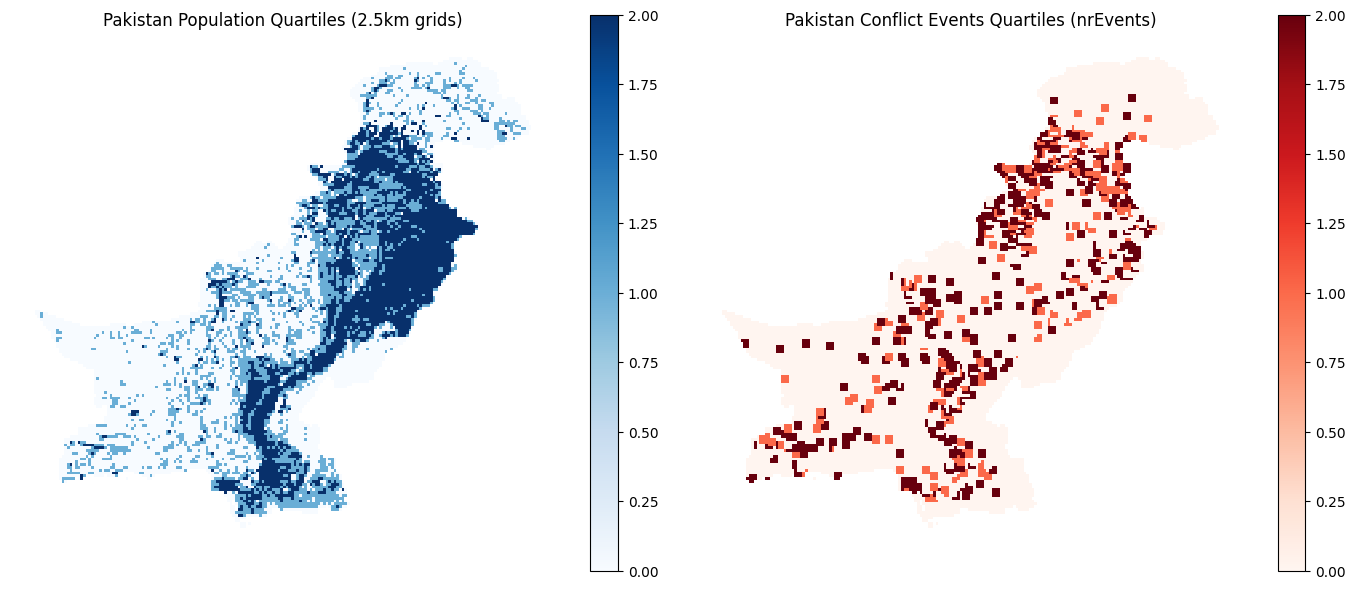

In [329]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot population quartiles
pak.plot(column='population_quartile', ax=axes[0], legend=True, cmap='Blues')
axes[0].set_title('Pakistan Population Quartiles (2.5km grids)')
axes[0].axis('off')

# Merge conflict data with population grid
pak_merged = pak.sjoin(pak_conflict, how='left', predicate='intersects')

# Create quartiles for nrEvents
pak_merged['nrEvents_quartile'] = pd.qcut(pak_merged['nrEvents'].fillna(0), 4, labels=False, duplicates='drop')

pak_merged.plot(column='nrEvents_quartile', ax=axes[1], legend=True, cmap='Reds')
axes[1].set_title('Pakistan Conflict Events Quartiles (nrEvents)')
axes[1].axis('off')

plt.tight_layout()
plt.show()
#pak.sjoin(pak_conflict)

### Affected Population (No Peaceful Protests)

#### Methodology Notes

**Data Sources:** ACLED conflict data (2019-2024) and WorldPop 2020 population estimates

**Conflict Definition:** Includes Battles, Riots, Strategic Developments, Violence against civilians, and Explosions/Remote violence. Excludes peaceful protests but includes protest-related violence where specified(Protest with intervention, Excessive force against protesters).

**Spatial Analysis:** Population and conflict events aggregated to 2.5 sq.km grid cells

**Disclaimers:** Egypt's population has grown >10% since 2020 baseline data

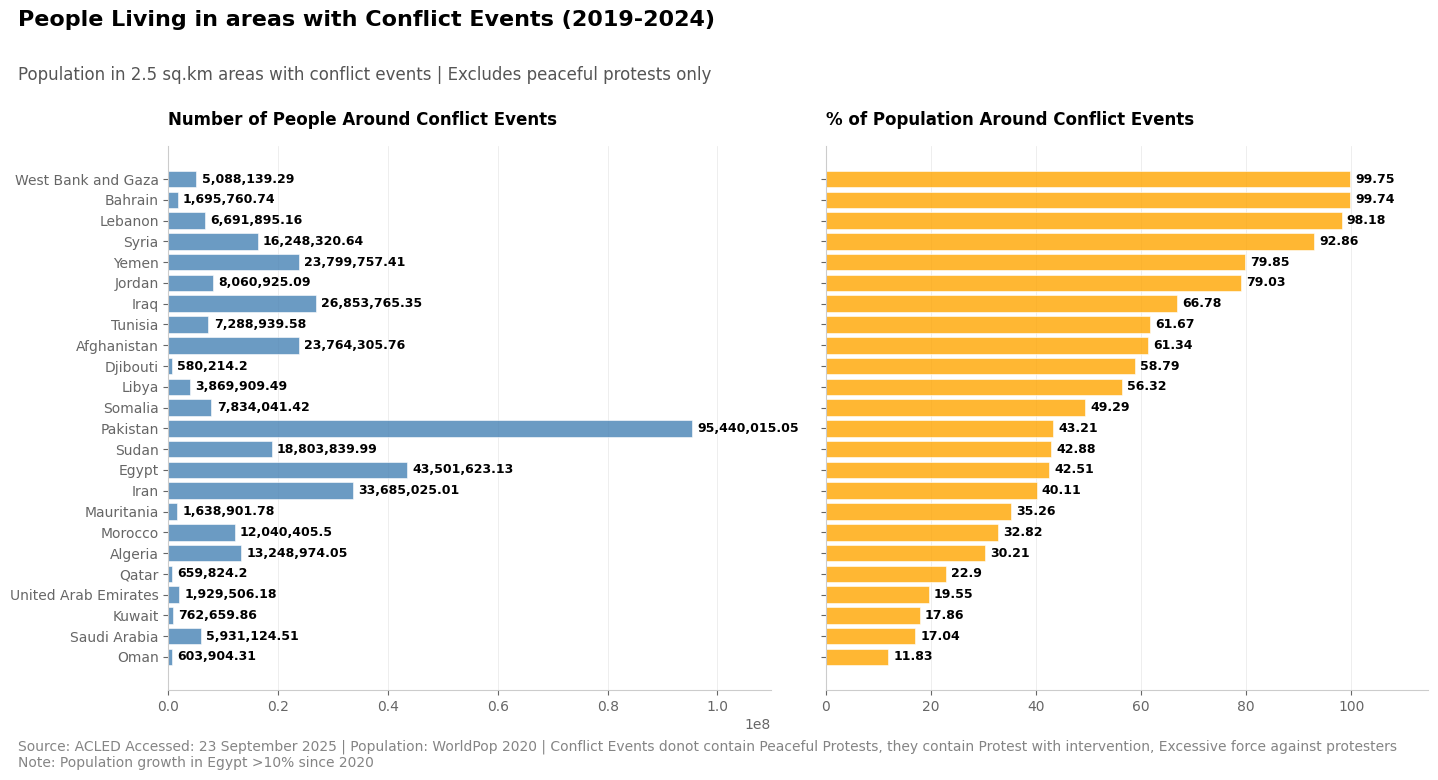

In [457]:
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('default')

plot_dual_metrics_by_country(
    data =merged,
    metrics_to_plot =['population', 'pc_population'],
    metric_display_info = {'population': {'title': 'Number of People Around Conflict Events', 'color': 'steelblue'},
                           'pc_population': {'title': '% of Population Around Conflict Events', 'color': 'orange'}},
    sorting_metric = 'pc_population',
    overall_title = 'People Living in areas with Conflict Events (2019-2024)',
    chart_subtitle='Population in 2.5 sq.km areas with conflict events | Excludes peaceful protests only',
    source_text = f'Source: ACLED Accessed: {extracted_date_formatted} | Population: WorldPop 2020 | Conflict Events donot contain Peaceful Protests, they contain Protest with intervention, Excessive force against protesters\nNote: Population growth in Egypt >10% since 2020'
);

### Affected Population (No Protests)

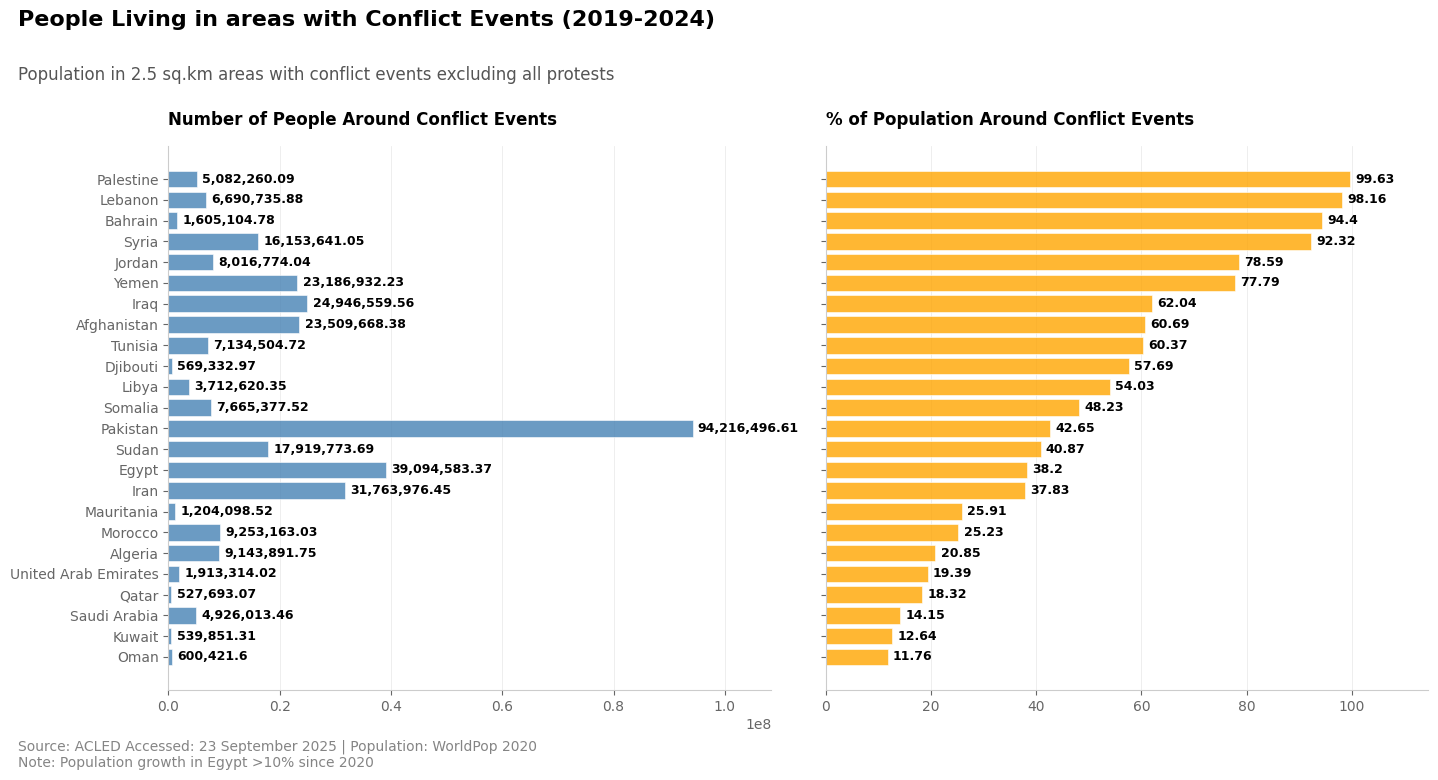

In [452]:
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('default')

plot_dual_metrics_by_country(
    data =merged_noprotest,
    metrics_to_plot =['population', 'pc_population'],
    metric_display_info = {'population': {'title': 'Number of People Around Conflict Events', 'color': 'steelblue'},
                           'pc_population': {'title': '% of Population Around Conflict Events', 'color': 'orange'}},
    sorting_metric = 'pc_population',
    overall_title = 'People Living in areas with Conflict Events (2019-2024)',
    chart_subtitle='Population in 2.5 sq.km areas with conflict events excluding all protests',
    source_text = f'Source: ACLED Accessed: {extracted_date_formatted} | Population: WorldPop 2020 \nNote: Population growth in Egypt >10% since 2020'
);

### Population living around atleast 10 conflict events

In [414]:
conflict_national_q12_min1 = conflict_national_q12[conflict_national_q12['nrEvents']>10]
merged_min1 = conflict_national_q12_min1.merge(pop[['index', 'population', 'country']],on=['index', 'country'], how='left')
merged_min1 = merged_min1.groupby(['country', 'country_code'])[['nrEvents', 'nrFatalities', 'population']].sum().reset_index()
merged_min1 = merged_min1.merge(pop_country, on=['country_code', 'country'])
merged_min1['pc_population'] = 100*merged_min1['population']/merged_min1['totalPopulation']

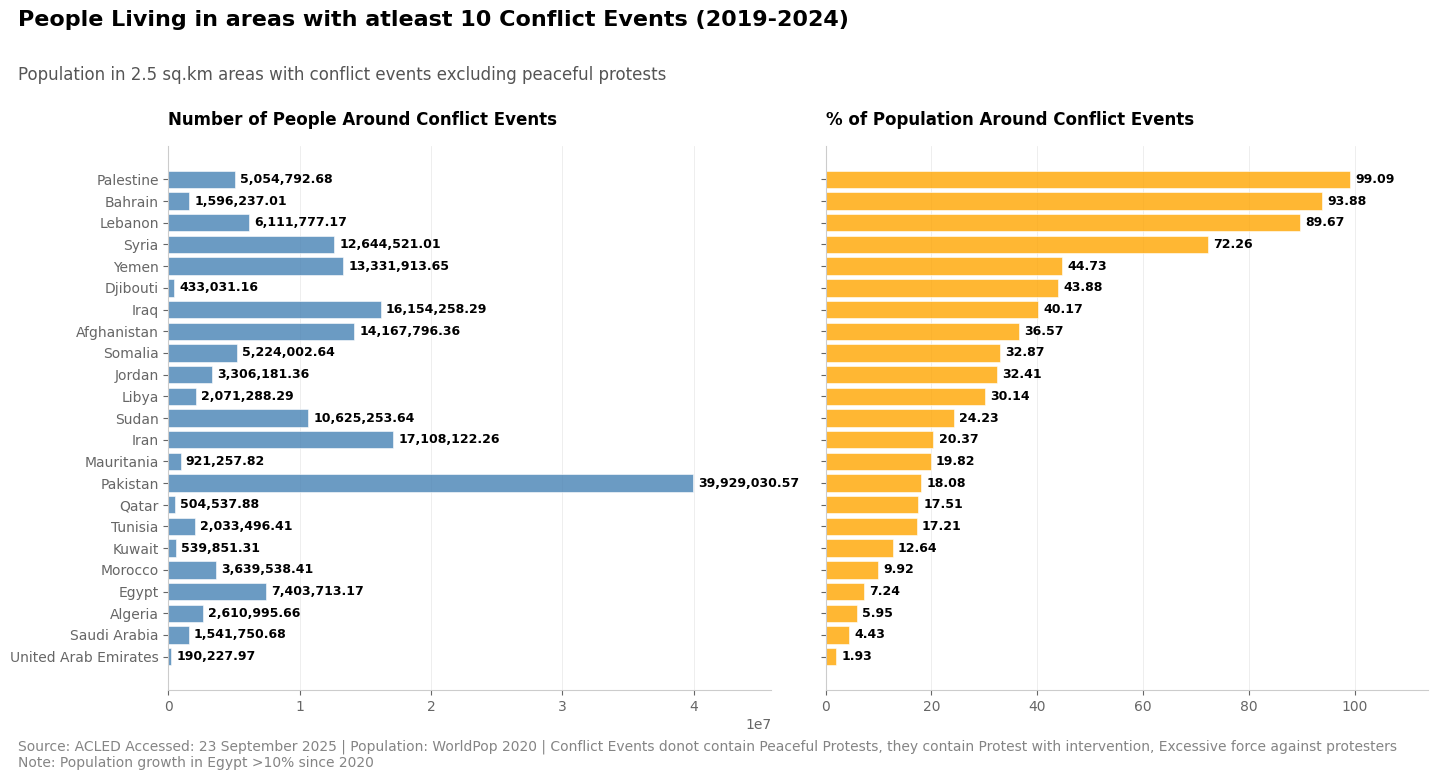

In [458]:
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('default')

plot_dual_metrics_by_country(
    data =merged_min1,
    metrics_to_plot =['population', 'pc_population'],
    metric_display_info = {'population': {'title': 'Number of People Around Conflict Events', 'color': 'steelblue'},
                           'pc_population': {'title': '% of Population Around Conflict Events', 'color': 'orange'}},
    sorting_metric = 'pc_population',
    overall_title = 'People Living in areas with atleast 10 Conflict Events (2019-2024)',
    chart_subtitle='Population in 2.5 sq.km areas with conflict events excluding peaceful protests',
    source_text = f'Source: ACLED Accessed: {extracted_date_formatted} | Population: WorldPop 2020 | Conflict Events donot contain Peaceful Protests, they contain Protest with intervention, Excessive force against protesters\nNote: Population growth in Egypt >10% since 2020'
);

In [455]:
merged.to_csv(f'../../data/conflict/population_by_conflict_quad12_{extracted_date}.csv')
merged_min1.to_csv(f'../../data/conflict/population_by_conflict_quad12_min10_{extracted_date}.csv')

## Conflict Type Trends

In [272]:
regional_conflict_event = processing.get_acled_by_group(data, ['event_type', 'sub_event_type'], freq ='MS')

### Regional Conflict Type Analysis

In [273]:
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.models import TabPanel, Tabs # Panel is deprecated in newer Bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
import bokeh.core.validation # Import the module to access silence
bokeh.core.validation.silence(MISSING_RENDERERS, True)
bokeh.core.validation.silence(EMPTY_LAYOUT, True) # Added for completeness if this also occurs

output_notebook() # Ensure this is called if running in a notebook environment

tabs = []

measures = regional_conflict_event['event_type'].unique()

for idx, measure in enumerate(measures):
    # Get the line plot using the provided visuals_module
    p = visuals.get_line_plot(
        regional_conflict_event[regional_conflict_event['event_type']==measure],
        title = f'{measure} Monthly Conflict Events',
        source=f"Source: ACLED. Accessed: {extracted_date_formatted}",
        category='sub_event_type',
        measure='nrEvents',
        event_date='event_date'
    )

    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with tabs
bokeh_tabs_display = Tabs(tabs=tabs, sizing_mode="scale_both")
show(bokeh_tabs_display, warn_on_missing_glyphs=False)

Loading BokehJS ...

- The non violent transfer of territory took place in Syria, Yemen, Lebanon and Libya. In Lebanon, at the end of 2024,the Lebanese Armed Forces took control of southern Lebanon previously held by the Hezbollah. In 2024 December, Israeli forces took control of parts of Syria. 
- The uptick in the 'Non-state actor overtaking territory' alludes to the events occuring in Syria between the Syrian Democratic Forces, Syrian National Army, Tribal and Clain forces etc. 
- The number of air drone strikes in the region have incerased from 2022 to 2024. Non-state actors are involved in some of the drone attacks. 


In [274]:
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.models import TabPanel, Tabs # Panel is deprecated in newer Bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
import bokeh.core.validation # Import the module to access silence
bokeh.core.validation.silence(MISSING_RENDERERS, True)
bokeh.core.validation.silence(EMPTY_LAYOUT, True) # Added for completeness if this also occurs

output_notebook() # Ensure this is called if running in a notebook environment



tabs = []

measures = countries_of_interest

conflict_event_monthly = conflict_event_monthly.sort_values(by=['country', 'event_type'])

for idx, measure in enumerate(measures):
    # Get the line plot using the provided visuals_module
    p = visuals.get_line_plot(
        conflict_event_monthly[conflict_event_monthly['country'] == measure],
        title = f'{measure} Monthly Conflict Events',
        source=f"Source: ACLED. Accessed: {extracted_date_formatted}. Data does not include peaceful protests.",
        category='event_type',
        measure='nrEvents',
        event_date='event_date'
    )

    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with tabs
bokeh_tabs_display = Tabs(tabs=tabs, sizing_mode="scale_both")
show(bokeh_tabs_display, warn_on_missing_glyphs=False)

Loading BokehJS ...